# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
from torch.utils.data import DataLoader

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    
    # define dataset using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)
    
    # create and return DataLoader
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
   
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

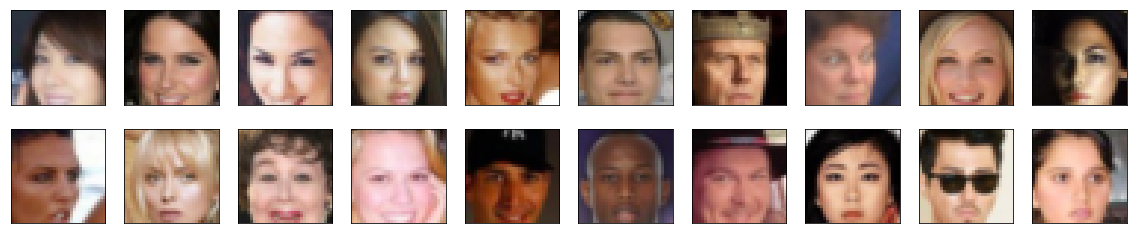

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(0.9137)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)         
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out,smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # 2. Train with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
           
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.2560 | g_loss: 0.7851
Epoch [    1/   50] | d_loss: 0.5236 | g_loss: 2.2430
Epoch [    1/   50] | d_loss: 0.4013 | g_loss: 3.0574
Epoch [    1/   50] | d_loss: 0.3948 | g_loss: 3.4012
Epoch [    1/   50] | d_loss: 0.5070 | g_loss: 2.3419
Epoch [    1/   50] | d_loss: 0.7445 | g_loss: 1.6546
Epoch [    1/   50] | d_loss: 0.5711 | g_loss: 1.9484
Epoch [    1/   50] | d_loss: 0.6996 | g_loss: 2.7956
Epoch [    1/   50] | d_loss: 0.8322 | g_loss: 1.6944
Epoch [    1/   50] | d_loss: 0.7224 | g_loss: 1.8058
Epoch [    1/   50] | d_loss: 0.7890 | g_loss: 1.0334
Epoch [    1/   50] | d_loss: 0.9064 | g_loss: 1.4340
Epoch [    1/   50] | d_loss: 0.8386 | g_loss: 1.6865
Epoch [    1/   50] | d_loss: 0.8796 | g_loss: 1.9491
Epoch [    1/   50] | d_loss: 0.8678 | g_loss: 1.8377
Epoch [    1/   50] | d_loss: 1.1451 | g_loss: 0.8719
Epoch [    1/   50] | d_loss: 0.9794 | g_loss: 2.1712
Epoch [    1/   50] | d_loss: 1.1927 | g_loss: 1.1842
Epoch [    1/   50] | d_loss

Epoch [    2/   50] | d_loss: 1.0156 | g_loss: 0.9725
Epoch [    2/   50] | d_loss: 1.1048 | g_loss: 1.1336
Epoch [    2/   50] | d_loss: 1.3761 | g_loss: 0.7989
Epoch [    2/   50] | d_loss: 0.9667 | g_loss: 1.2465
Epoch [    2/   50] | d_loss: 0.9468 | g_loss: 1.4172
Epoch [    2/   50] | d_loss: 1.1507 | g_loss: 1.4699
Epoch [    2/   50] | d_loss: 1.0515 | g_loss: 1.4028
Epoch [    2/   50] | d_loss: 0.9052 | g_loss: 1.7174
Epoch [    2/   50] | d_loss: 0.9168 | g_loss: 1.3712
Epoch [    2/   50] | d_loss: 1.1803 | g_loss: 0.9494
Epoch [    2/   50] | d_loss: 1.0441 | g_loss: 1.7553
Epoch [    2/   50] | d_loss: 1.1869 | g_loss: 1.4651
Epoch [    2/   50] | d_loss: 1.1348 | g_loss: 1.1651
Epoch [    2/   50] | d_loss: 1.1090 | g_loss: 1.2720
Epoch [    2/   50] | d_loss: 1.1448 | g_loss: 1.0990
Epoch [    2/   50] | d_loss: 1.0657 | g_loss: 1.2352
Epoch [    2/   50] | d_loss: 0.9576 | g_loss: 0.9548
Epoch [    2/   50] | d_loss: 0.9180 | g_loss: 1.4048
Epoch [    2/   50] | d_loss

Epoch [    4/   50] | d_loss: 1.0761 | g_loss: 1.1333
Epoch [    4/   50] | d_loss: 0.9896 | g_loss: 1.0288
Epoch [    4/   50] | d_loss: 0.8853 | g_loss: 1.4547
Epoch [    4/   50] | d_loss: 0.9831 | g_loss: 1.6649
Epoch [    4/   50] | d_loss: 0.9685 | g_loss: 0.7211
Epoch [    4/   50] | d_loss: 1.6113 | g_loss: 2.1490
Epoch [    4/   50] | d_loss: 1.0104 | g_loss: 1.7780
Epoch [    4/   50] | d_loss: 0.9622 | g_loss: 1.6835
Epoch [    4/   50] | d_loss: 1.1373 | g_loss: 1.2410
Epoch [    4/   50] | d_loss: 1.2221 | g_loss: 1.0112
Epoch [    4/   50] | d_loss: 0.5936 | g_loss: 1.9278
Epoch [    4/   50] | d_loss: 1.2207 | g_loss: 1.6803
Epoch [    4/   50] | d_loss: 1.1464 | g_loss: 1.7117
Epoch [    4/   50] | d_loss: 0.6456 | g_loss: 1.5222
Epoch [    4/   50] | d_loss: 1.0394 | g_loss: 1.4864
Epoch [    4/   50] | d_loss: 1.0802 | g_loss: 1.5061
Epoch [    4/   50] | d_loss: 0.8647 | g_loss: 1.1458
Epoch [    4/   50] | d_loss: 1.1479 | g_loss: 1.2610
Epoch [    4/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.7030 | g_loss: 1.5041
Epoch [    6/   50] | d_loss: 0.8658 | g_loss: 1.7390
Epoch [    6/   50] | d_loss: 0.8176 | g_loss: 2.1767
Epoch [    6/   50] | d_loss: 0.6926 | g_loss: 1.4294
Epoch [    6/   50] | d_loss: 0.8267 | g_loss: 1.7556
Epoch [    6/   50] | d_loss: 0.9433 | g_loss: 0.8189
Epoch [    6/   50] | d_loss: 0.6852 | g_loss: 1.6863
Epoch [    6/   50] | d_loss: 0.7963 | g_loss: 1.1814
Epoch [    6/   50] | d_loss: 0.8642 | g_loss: 1.9555
Epoch [    6/   50] | d_loss: 0.7189 | g_loss: 1.9751
Epoch [    6/   50] | d_loss: 0.9338 | g_loss: 1.5638
Epoch [    6/   50] | d_loss: 0.8317 | g_loss: 2.0723
Epoch [    6/   50] | d_loss: 0.7806 | g_loss: 1.1578
Epoch [    6/   50] | d_loss: 0.9718 | g_loss: 2.2068
Epoch [    6/   50] | d_loss: 0.7516 | g_loss: 1.6986
Epoch [    6/   50] | d_loss: 0.8982 | g_loss: 1.6144
Epoch [    6/   50] | d_loss: 1.1229 | g_loss: 1.4338
Epoch [    6/   50] | d_loss: 0.8581 | g_loss: 1.7119
Epoch [    6/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.8837 | g_loss: 1.2388
Epoch [    7/   50] | d_loss: 0.6742 | g_loss: 2.2356
Epoch [    7/   50] | d_loss: 0.9030 | g_loss: 1.8388
Epoch [    7/   50] | d_loss: 0.6298 | g_loss: 1.9556
Epoch [    7/   50] | d_loss: 0.6288 | g_loss: 1.5774
Epoch [    7/   50] | d_loss: 0.9260 | g_loss: 1.6668
Epoch [    7/   50] | d_loss: 0.9521 | g_loss: 1.7697
Epoch [    7/   50] | d_loss: 0.8603 | g_loss: 1.5432
Epoch [    7/   50] | d_loss: 0.7677 | g_loss: 1.6159
Epoch [    7/   50] | d_loss: 0.6345 | g_loss: 2.2473
Epoch [    7/   50] | d_loss: 0.8125 | g_loss: 2.2010
Epoch [    7/   50] | d_loss: 0.6599 | g_loss: 1.9128
Epoch [    7/   50] | d_loss: 1.3197 | g_loss: 1.8906
Epoch [    7/   50] | d_loss: 0.5845 | g_loss: 2.5979
Epoch [    7/   50] | d_loss: 1.0933 | g_loss: 2.0796
Epoch [    7/   50] | d_loss: 1.2787 | g_loss: 1.3311
Epoch [    7/   50] | d_loss: 0.6369 | g_loss: 1.8160
Epoch [    7/   50] | d_loss: 0.9815 | g_loss: 2.0584
Epoch [    7/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.8908 | g_loss: 2.1973
Epoch [    9/   50] | d_loss: 0.7199 | g_loss: 1.5456
Epoch [    9/   50] | d_loss: 0.7005 | g_loss: 1.4149
Epoch [    9/   50] | d_loss: 0.6823 | g_loss: 2.1457
Epoch [    9/   50] | d_loss: 0.4262 | g_loss: 2.2987
Epoch [    9/   50] | d_loss: 0.5828 | g_loss: 2.4500
Epoch [    9/   50] | d_loss: 0.8690 | g_loss: 2.8243
Epoch [    9/   50] | d_loss: 0.7338 | g_loss: 0.9678
Epoch [    9/   50] | d_loss: 0.6117 | g_loss: 1.6250
Epoch [    9/   50] | d_loss: 0.6730 | g_loss: 2.4125
Epoch [    9/   50] | d_loss: 0.5041 | g_loss: 2.1426
Epoch [    9/   50] | d_loss: 0.5113 | g_loss: 1.8075
Epoch [    9/   50] | d_loss: 0.7107 | g_loss: 2.3385
Epoch [    9/   50] | d_loss: 0.5374 | g_loss: 2.3128
Epoch [    9/   50] | d_loss: 0.8945 | g_loss: 1.8442
Epoch [    9/   50] | d_loss: 0.7681 | g_loss: 1.8122
Epoch [    9/   50] | d_loss: 0.5456 | g_loss: 1.2525
Epoch [    9/   50] | d_loss: 0.8184 | g_loss: 2.0451
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.7519 | g_loss: 1.7531
Epoch [   11/   50] | d_loss: 0.5640 | g_loss: 2.0826
Epoch [   11/   50] | d_loss: 0.6213 | g_loss: 3.3157
Epoch [   11/   50] | d_loss: 0.7484 | g_loss: 1.7937
Epoch [   11/   50] | d_loss: 0.5364 | g_loss: 2.4693
Epoch [   11/   50] | d_loss: 0.4646 | g_loss: 1.9872
Epoch [   11/   50] | d_loss: 0.8116 | g_loss: 2.7431
Epoch [   11/   50] | d_loss: 0.5317 | g_loss: 2.4463
Epoch [   11/   50] | d_loss: 0.4955 | g_loss: 2.5633
Epoch [   11/   50] | d_loss: 0.5548 | g_loss: 2.5427
Epoch [   11/   50] | d_loss: 0.7758 | g_loss: 1.5240
Epoch [   11/   50] | d_loss: 0.7208 | g_loss: 2.2386
Epoch [   11/   50] | d_loss: 1.0031 | g_loss: 1.3956
Epoch [   11/   50] | d_loss: 0.7228 | g_loss: 2.4769
Epoch [   11/   50] | d_loss: 0.9487 | g_loss: 1.4129
Epoch [   11/   50] | d_loss: 0.7480 | g_loss: 1.8373
Epoch [   11/   50] | d_loss: 0.6241 | g_loss: 3.2237
Epoch [   11/   50] | d_loss: 0.7445 | g_loss: 1.5681
Epoch [   11/   50] | d_loss

Epoch [   12/   50] | d_loss: 1.1293 | g_loss: 2.1969
Epoch [   12/   50] | d_loss: 0.4669 | g_loss: 3.2910
Epoch [   12/   50] | d_loss: 0.5980 | g_loss: 2.1523
Epoch [   12/   50] | d_loss: 0.6610 | g_loss: 2.3325
Epoch [   12/   50] | d_loss: 0.5956 | g_loss: 1.9584
Epoch [   12/   50] | d_loss: 0.6231 | g_loss: 2.5961
Epoch [   12/   50] | d_loss: 0.5717 | g_loss: 1.9007
Epoch [   12/   50] | d_loss: 0.8102 | g_loss: 2.3277
Epoch [   12/   50] | d_loss: 0.5246 | g_loss: 2.7721
Epoch [   12/   50] | d_loss: 0.7312 | g_loss: 1.5941
Epoch [   12/   50] | d_loss: 0.6056 | g_loss: 1.6668
Epoch [   12/   50] | d_loss: 0.7119 | g_loss: 2.1622
Epoch [   12/   50] | d_loss: 0.7389 | g_loss: 3.6272
Epoch [   12/   50] | d_loss: 0.5677 | g_loss: 2.5692
Epoch [   12/   50] | d_loss: 0.4774 | g_loss: 2.6141
Epoch [   12/   50] | d_loss: 0.6068 | g_loss: 2.0003
Epoch [   13/   50] | d_loss: 0.5403 | g_loss: 3.1654
Epoch [   13/   50] | d_loss: 0.6690 | g_loss: 2.2086
Epoch [   13/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.7105 | g_loss: 3.0548
Epoch [   14/   50] | d_loss: 0.5390 | g_loss: 2.3467
Epoch [   14/   50] | d_loss: 0.8309 | g_loss: 3.1523
Epoch [   14/   50] | d_loss: 0.9051 | g_loss: 1.9463
Epoch [   14/   50] | d_loss: 0.5002 | g_loss: 1.8893
Epoch [   14/   50] | d_loss: 0.7284 | g_loss: 2.2443
Epoch [   14/   50] | d_loss: 0.4846 | g_loss: 3.3302
Epoch [   14/   50] | d_loss: 0.4867 | g_loss: 2.5785
Epoch [   14/   50] | d_loss: 0.6421 | g_loss: 1.4406
Epoch [   14/   50] | d_loss: 0.6312 | g_loss: 1.7736
Epoch [   14/   50] | d_loss: 0.6739 | g_loss: 3.3605
Epoch [   14/   50] | d_loss: 0.5193 | g_loss: 1.8037
Epoch [   14/   50] | d_loss: 0.5771 | g_loss: 3.3171
Epoch [   14/   50] | d_loss: 0.5450 | g_loss: 3.3735
Epoch [   14/   50] | d_loss: 0.5892 | g_loss: 2.1682
Epoch [   14/   50] | d_loss: 0.5359 | g_loss: 2.9840
Epoch [   14/   50] | d_loss: 0.5969 | g_loss: 1.9157
Epoch [   14/   50] | d_loss: 0.5637 | g_loss: 2.9768
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.6281 | g_loss: 1.5388
Epoch [   16/   50] | d_loss: 0.6194 | g_loss: 2.7375
Epoch [   16/   50] | d_loss: 0.5057 | g_loss: 2.5438
Epoch [   16/   50] | d_loss: 0.5656 | g_loss: 2.7064
Epoch [   16/   50] | d_loss: 0.6021 | g_loss: 2.1611
Epoch [   16/   50] | d_loss: 0.4904 | g_loss: 3.6685
Epoch [   16/   50] | d_loss: 0.5817 | g_loss: 2.2764
Epoch [   16/   50] | d_loss: 0.6060 | g_loss: 3.0549
Epoch [   16/   50] | d_loss: 0.7604 | g_loss: 3.0288
Epoch [   16/   50] | d_loss: 0.4148 | g_loss: 3.6702
Epoch [   16/   50] | d_loss: 0.4438 | g_loss: 3.2192
Epoch [   16/   50] | d_loss: 0.5928 | g_loss: 2.4354
Epoch [   16/   50] | d_loss: 0.4903 | g_loss: 3.1729
Epoch [   16/   50] | d_loss: 0.6126 | g_loss: 3.0659
Epoch [   16/   50] | d_loss: 0.4800 | g_loss: 2.7470
Epoch [   16/   50] | d_loss: 0.4394 | g_loss: 2.0103
Epoch [   16/   50] | d_loss: 0.6887 | g_loss: 1.8596
Epoch [   16/   50] | d_loss: 0.4734 | g_loss: 2.0784
Epoch [   16/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.4410 | g_loss: 3.5717
Epoch [   17/   50] | d_loss: 0.4434 | g_loss: 3.0853
Epoch [   17/   50] | d_loss: 0.4390 | g_loss: 3.5446
Epoch [   17/   50] | d_loss: 0.4420 | g_loss: 3.5763
Epoch [   17/   50] | d_loss: 0.5615 | g_loss: 2.4983
Epoch [   17/   50] | d_loss: 0.8061 | g_loss: 2.4596
Epoch [   17/   50] | d_loss: 0.5205 | g_loss: 1.4164
Epoch [   17/   50] | d_loss: 0.6180 | g_loss: 2.0752
Epoch [   17/   50] | d_loss: 0.9594 | g_loss: 2.1392
Epoch [   17/   50] | d_loss: 0.4750 | g_loss: 3.4041
Epoch [   18/   50] | d_loss: 0.4979 | g_loss: 2.6845
Epoch [   18/   50] | d_loss: 0.5094 | g_loss: 3.9062
Epoch [   18/   50] | d_loss: 0.4767 | g_loss: 2.8905
Epoch [   18/   50] | d_loss: 0.5373 | g_loss: 2.3962
Epoch [   18/   50] | d_loss: 0.4993 | g_loss: 2.7358
Epoch [   18/   50] | d_loss: 0.5943 | g_loss: 2.5408
Epoch [   18/   50] | d_loss: 0.4559 | g_loss: 1.4727
Epoch [   18/   50] | d_loss: 0.4351 | g_loss: 4.4334
Epoch [   18/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.4626 | g_loss: 3.0190
Epoch [   19/   50] | d_loss: 0.4370 | g_loss: 3.4612
Epoch [   19/   50] | d_loss: 0.6432 | g_loss: 2.4697
Epoch [   19/   50] | d_loss: 0.5074 | g_loss: 3.1092
Epoch [   19/   50] | d_loss: 0.5362 | g_loss: 2.0576
Epoch [   19/   50] | d_loss: 0.5026 | g_loss: 1.9732
Epoch [   19/   50] | d_loss: 0.8278 | g_loss: 3.4497
Epoch [   19/   50] | d_loss: 1.0062 | g_loss: 2.1300
Epoch [   19/   50] | d_loss: 0.6296 | g_loss: 3.9755
Epoch [   19/   50] | d_loss: 0.4403 | g_loss: 3.0267
Epoch [   19/   50] | d_loss: 0.7238 | g_loss: 3.1975
Epoch [   19/   50] | d_loss: 0.5499 | g_loss: 2.3537
Epoch [   19/   50] | d_loss: 0.4274 | g_loss: 2.5776
Epoch [   19/   50] | d_loss: 0.5065 | g_loss: 3.0562
Epoch [   19/   50] | d_loss: 0.4350 | g_loss: 3.5901
Epoch [   19/   50] | d_loss: 0.4690 | g_loss: 1.8947
Epoch [   19/   50] | d_loss: 0.5221 | g_loss: 3.2240
Epoch [   19/   50] | d_loss: 0.5001 | g_loss: 2.0432
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.4440 | g_loss: 3.8777
Epoch [   21/   50] | d_loss: 0.8332 | g_loss: 2.3913
Epoch [   21/   50] | d_loss: 0.5844 | g_loss: 4.1781
Epoch [   21/   50] | d_loss: 0.4839 | g_loss: 3.6054
Epoch [   21/   50] | d_loss: 0.4267 | g_loss: 2.3598
Epoch [   21/   50] | d_loss: 0.5203 | g_loss: 2.8561
Epoch [   21/   50] | d_loss: 0.4878 | g_loss: 2.1623
Epoch [   21/   50] | d_loss: 0.4607 | g_loss: 4.1088
Epoch [   21/   50] | d_loss: 0.4341 | g_loss: 3.1389
Epoch [   21/   50] | d_loss: 0.4504 | g_loss: 3.6779
Epoch [   21/   50] | d_loss: 0.4714 | g_loss: 3.8343
Epoch [   21/   50] | d_loss: 0.6570 | g_loss: 2.2186
Epoch [   21/   50] | d_loss: 0.4484 | g_loss: 4.8374
Epoch [   21/   50] | d_loss: 0.4880 | g_loss: 2.9947
Epoch [   21/   50] | d_loss: 0.6602 | g_loss: 3.5663
Epoch [   21/   50] | d_loss: 0.5030 | g_loss: 3.9149
Epoch [   21/   50] | d_loss: 0.4820 | g_loss: 2.9165
Epoch [   21/   50] | d_loss: 0.5815 | g_loss: 3.5465
Epoch [   21/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.4848 | g_loss: 3.6105
Epoch [   22/   50] | d_loss: 0.5333 | g_loss: 3.2208
Epoch [   22/   50] | d_loss: 0.6529 | g_loss: 3.5985
Epoch [   22/   50] | d_loss: 0.4425 | g_loss: 2.9155
Epoch [   23/   50] | d_loss: 0.5340 | g_loss: 3.6430
Epoch [   23/   50] | d_loss: 0.4215 | g_loss: 3.7238
Epoch [   23/   50] | d_loss: 0.5244 | g_loss: 3.0075
Epoch [   23/   50] | d_loss: 0.7154 | g_loss: 2.2192
Epoch [   23/   50] | d_loss: 0.4950 | g_loss: 3.3443
Epoch [   23/   50] | d_loss: 0.4940 | g_loss: 2.5840
Epoch [   23/   50] | d_loss: 0.5840 | g_loss: 2.9830
Epoch [   23/   50] | d_loss: 0.5278 | g_loss: 3.0802
Epoch [   23/   50] | d_loss: 0.4849 | g_loss: 2.1335
Epoch [   23/   50] | d_loss: 0.5023 | g_loss: 2.8814
Epoch [   23/   50] | d_loss: 0.4461 | g_loss: 2.9333
Epoch [   23/   50] | d_loss: 0.7076 | g_loss: 2.8966
Epoch [   23/   50] | d_loss: 0.7318 | g_loss: 1.5071
Epoch [   23/   50] | d_loss: 0.6604 | g_loss: 2.6604
Epoch [   23/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.4553 | g_loss: 2.8086
Epoch [   24/   50] | d_loss: 0.6199 | g_loss: 1.9706
Epoch [   24/   50] | d_loss: 0.4379 | g_loss: 3.7021
Epoch [   24/   50] | d_loss: 0.3962 | g_loss: 4.7120
Epoch [   24/   50] | d_loss: 0.4268 | g_loss: 3.4129
Epoch [   24/   50] | d_loss: 0.4509 | g_loss: 3.3092
Epoch [   24/   50] | d_loss: 0.5554 | g_loss: 2.4554
Epoch [   24/   50] | d_loss: 0.4366 | g_loss: 3.1401
Epoch [   24/   50] | d_loss: 0.4522 | g_loss: 3.5886
Epoch [   24/   50] | d_loss: 0.4110 | g_loss: 3.3341
Epoch [   24/   50] | d_loss: 0.4253 | g_loss: 3.1917
Epoch [   24/   50] | d_loss: 0.6622 | g_loss: 2.1853
Epoch [   24/   50] | d_loss: 0.4972 | g_loss: 2.3581
Epoch [   24/   50] | d_loss: 0.6507 | g_loss: 3.7023
Epoch [   24/   50] | d_loss: 1.0359 | g_loss: 2.1861
Epoch [   24/   50] | d_loss: 0.6049 | g_loss: 4.8629
Epoch [   24/   50] | d_loss: 0.4423 | g_loss: 3.1947
Epoch [   24/   50] | d_loss: 0.4674 | g_loss: 4.5940
Epoch [   24/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.4598 | g_loss: 3.5898
Epoch [   26/   50] | d_loss: 0.4321 | g_loss: 3.5979
Epoch [   26/   50] | d_loss: 0.4444 | g_loss: 3.0119
Epoch [   26/   50] | d_loss: 0.5260 | g_loss: 3.0029
Epoch [   26/   50] | d_loss: 0.5387 | g_loss: 3.2015
Epoch [   26/   50] | d_loss: 0.4579 | g_loss: 4.4627
Epoch [   26/   50] | d_loss: 0.5868 | g_loss: 3.0308
Epoch [   26/   50] | d_loss: 0.4771 | g_loss: 3.8153
Epoch [   26/   50] | d_loss: 0.4429 | g_loss: 2.6281
Epoch [   26/   50] | d_loss: 0.4666 | g_loss: 3.0745
Epoch [   26/   50] | d_loss: 0.4792 | g_loss: 4.7518
Epoch [   26/   50] | d_loss: 0.4494 | g_loss: 2.8532
Epoch [   26/   50] | d_loss: 0.3787 | g_loss: 4.1130
Epoch [   26/   50] | d_loss: 0.4207 | g_loss: 3.4026
Epoch [   26/   50] | d_loss: 0.5700 | g_loss: 2.7820
Epoch [   26/   50] | d_loss: 0.4099 | g_loss: 2.6660
Epoch [   26/   50] | d_loss: 0.6295 | g_loss: 4.1256
Epoch [   26/   50] | d_loss: 0.6281 | g_loss: 3.2926
Epoch [   26/   50] | d_loss

Epoch [   28/   50] | d_loss: 0.8245 | g_loss: 3.6760
Epoch [   28/   50] | d_loss: 0.9622 | g_loss: 1.9372
Epoch [   28/   50] | d_loss: 0.5044 | g_loss: 2.3888
Epoch [   28/   50] | d_loss: 0.4110 | g_loss: 4.4506
Epoch [   28/   50] | d_loss: 0.4607 | g_loss: 2.2295
Epoch [   28/   50] | d_loss: 0.5373 | g_loss: 2.3052
Epoch [   28/   50] | d_loss: 0.4052 | g_loss: 2.3009
Epoch [   28/   50] | d_loss: 0.8932 | g_loss: 2.1773
Epoch [   28/   50] | d_loss: 0.4656 | g_loss: 3.3950
Epoch [   28/   50] | d_loss: 0.7193 | g_loss: 2.8843
Epoch [   28/   50] | d_loss: 0.4593 | g_loss: 3.1306
Epoch [   28/   50] | d_loss: 0.4505 | g_loss: 4.4152
Epoch [   28/   50] | d_loss: 0.5071 | g_loss: 1.9618
Epoch [   28/   50] | d_loss: 0.4711 | g_loss: 2.2894
Epoch [   28/   50] | d_loss: 0.4393 | g_loss: 2.7703
Epoch [   28/   50] | d_loss: 0.4798 | g_loss: 3.1311
Epoch [   28/   50] | d_loss: 0.3828 | g_loss: 4.2536
Epoch [   28/   50] | d_loss: 0.5470 | g_loss: 4.5361
Epoch [   28/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.3886 | g_loss: 4.0160
Epoch [   29/   50] | d_loss: 0.5265 | g_loss: 2.2733
Epoch [   29/   50] | d_loss: 0.4731 | g_loss: 3.9992
Epoch [   29/   50] | d_loss: 0.4360 | g_loss: 3.5967
Epoch [   29/   50] | d_loss: 0.5181 | g_loss: 2.0859
Epoch [   29/   50] | d_loss: 0.4286 | g_loss: 2.9129
Epoch [   29/   50] | d_loss: 0.4207 | g_loss: 3.9383
Epoch [   29/   50] | d_loss: 0.5974 | g_loss: 2.9673
Epoch [   29/   50] | d_loss: 0.5121 | g_loss: 2.7983
Epoch [   29/   50] | d_loss: 0.5716 | g_loss: 4.0980
Epoch [   29/   50] | d_loss: 0.4043 | g_loss: 4.1952
Epoch [   29/   50] | d_loss: 0.4815 | g_loss: 3.3026
Epoch [   29/   50] | d_loss: 0.5338 | g_loss: 3.0504
Epoch [   29/   50] | d_loss: 0.4231 | g_loss: 2.7578
Epoch [   29/   50] | d_loss: 0.4161 | g_loss: 3.9259
Epoch [   29/   50] | d_loss: 0.4915 | g_loss: 3.3411
Epoch [   29/   50] | d_loss: 0.5412 | g_loss: 3.8229
Epoch [   29/   50] | d_loss: 0.4234 | g_loss: 3.0214
Epoch [   29/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.6612 | g_loss: 3.1271
Epoch [   31/   50] | d_loss: 0.7004 | g_loss: 3.2375
Epoch [   31/   50] | d_loss: 0.4070 | g_loss: 3.2933
Epoch [   31/   50] | d_loss: 0.4778 | g_loss: 3.3090
Epoch [   31/   50] | d_loss: 0.3929 | g_loss: 3.1605
Epoch [   31/   50] | d_loss: 0.4061 | g_loss: 4.5311
Epoch [   31/   50] | d_loss: 0.4316 | g_loss: 3.1472
Epoch [   31/   50] | d_loss: 0.4176 | g_loss: 3.0584
Epoch [   31/   50] | d_loss: 0.4405 | g_loss: 3.5181
Epoch [   31/   50] | d_loss: 0.4182 | g_loss: 2.1310
Epoch [   31/   50] | d_loss: 0.4625 | g_loss: 3.9779
Epoch [   31/   50] | d_loss: 0.6630 | g_loss: 3.7711
Epoch [   31/   50] | d_loss: 0.4316 | g_loss: 3.4240
Epoch [   31/   50] | d_loss: 0.5632 | g_loss: 3.6782
Epoch [   31/   50] | d_loss: 0.4779 | g_loss: 3.7548
Epoch [   31/   50] | d_loss: 0.5937 | g_loss: 2.7801
Epoch [   31/   50] | d_loss: 0.6339 | g_loss: 2.8591
Epoch [   31/   50] | d_loss: 0.8163 | g_loss: 2.1101
Epoch [   31/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.5709 | g_loss: 4.8255
Epoch [   33/   50] | d_loss: 0.7553 | g_loss: 3.0810
Epoch [   33/   50] | d_loss: 0.5018 | g_loss: 2.6128
Epoch [   33/   50] | d_loss: 0.6577 | g_loss: 3.2035
Epoch [   33/   50] | d_loss: 0.4321 | g_loss: 3.3994
Epoch [   33/   50] | d_loss: 0.4220 | g_loss: 2.0147
Epoch [   33/   50] | d_loss: 0.4355 | g_loss: 2.8936
Epoch [   33/   50] | d_loss: 0.3867 | g_loss: 4.4612
Epoch [   33/   50] | d_loss: 0.4659 | g_loss: 4.2574
Epoch [   33/   50] | d_loss: 0.4065 | g_loss: 3.3373
Epoch [   33/   50] | d_loss: 0.5429 | g_loss: 2.8580
Epoch [   33/   50] | d_loss: 0.4513 | g_loss: 3.5916
Epoch [   33/   50] | d_loss: 0.4081 | g_loss: 3.2120
Epoch [   33/   50] | d_loss: 0.5142 | g_loss: 3.0663
Epoch [   33/   50] | d_loss: 0.4385 | g_loss: 2.8328
Epoch [   33/   50] | d_loss: 0.4046 | g_loss: 3.3274
Epoch [   33/   50] | d_loss: 0.4103 | g_loss: 2.7798
Epoch [   33/   50] | d_loss: 0.4575 | g_loss: 3.4835
Epoch [   33/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.5143 | g_loss: 2.5395
Epoch [   34/   50] | d_loss: 0.5581 | g_loss: 2.5011
Epoch [   34/   50] | d_loss: 0.4363 | g_loss: 2.6123
Epoch [   34/   50] | d_loss: 0.4720 | g_loss: 3.6385
Epoch [   34/   50] | d_loss: 0.4547 | g_loss: 1.9142
Epoch [   34/   50] | d_loss: 0.4029 | g_loss: 4.1695
Epoch [   34/   50] | d_loss: 0.4698 | g_loss: 4.6923
Epoch [   34/   50] | d_loss: 0.4263 | g_loss: 2.3195
Epoch [   34/   50] | d_loss: 0.5454 | g_loss: 3.4502
Epoch [   34/   50] | d_loss: 0.4021 | g_loss: 4.5646
Epoch [   34/   50] | d_loss: 0.4068 | g_loss: 2.2211
Epoch [   34/   50] | d_loss: 0.7028 | g_loss: 2.5403
Epoch [   34/   50] | d_loss: 0.4612 | g_loss: 3.1351
Epoch [   34/   50] | d_loss: 1.4981 | g_loss: 0.6548
Epoch [   34/   50] | d_loss: 0.5906 | g_loss: 3.2074
Epoch [   34/   50] | d_loss: 0.5915 | g_loss: 3.4150
Epoch [   34/   50] | d_loss: 0.5382 | g_loss: 1.6881
Epoch [   34/   50] | d_loss: 0.4722 | g_loss: 3.5242
Epoch [   34/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.6828 | g_loss: 2.9007
Epoch [   36/   50] | d_loss: 0.4029 | g_loss: 3.1620
Epoch [   36/   50] | d_loss: 0.5145 | g_loss: 2.4697
Epoch [   36/   50] | d_loss: 0.5302 | g_loss: 1.8482
Epoch [   36/   50] | d_loss: 0.4904 | g_loss: 2.5347
Epoch [   36/   50] | d_loss: 0.4092 | g_loss: 3.1677
Epoch [   36/   50] | d_loss: 0.4805 | g_loss: 3.5736
Epoch [   36/   50] | d_loss: 0.3864 | g_loss: 3.4166
Epoch [   36/   50] | d_loss: 0.4299 | g_loss: 3.5780
Epoch [   36/   50] | d_loss: 0.4805 | g_loss: 3.3569
Epoch [   36/   50] | d_loss: 0.4705 | g_loss: 4.9773
Epoch [   36/   50] | d_loss: 0.5477 | g_loss: 3.8761
Epoch [   36/   50] | d_loss: 0.4856 | g_loss: 3.2461
Epoch [   36/   50] | d_loss: 0.5991 | g_loss: 2.3066
Epoch [   36/   50] | d_loss: 0.4735 | g_loss: 2.6964
Epoch [   36/   50] | d_loss: 0.7122 | g_loss: 1.9280
Epoch [   36/   50] | d_loss: 0.5865 | g_loss: 1.2588
Epoch [   36/   50] | d_loss: 0.3908 | g_loss: 4.9254
Epoch [   36/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.6233 | g_loss: 2.6707
Epoch [   38/   50] | d_loss: 0.3985 | g_loss: 4.1002
Epoch [   38/   50] | d_loss: 0.4858 | g_loss: 2.5712
Epoch [   38/   50] | d_loss: 0.5118 | g_loss: 2.4056
Epoch [   38/   50] | d_loss: 0.4216 | g_loss: 3.6581
Epoch [   38/   50] | d_loss: 0.4120 | g_loss: 3.2994
Epoch [   38/   50] | d_loss: 0.5232 | g_loss: 3.5664
Epoch [   38/   50] | d_loss: 0.3843 | g_loss: 3.2065
Epoch [   38/   50] | d_loss: 0.6144 | g_loss: 2.7287
Epoch [   38/   50] | d_loss: 0.5456 | g_loss: 3.4111
Epoch [   38/   50] | d_loss: 0.5252 | g_loss: 3.1448
Epoch [   38/   50] | d_loss: 0.4154 | g_loss: 3.0510
Epoch [   38/   50] | d_loss: 0.5580 | g_loss: 2.8719
Epoch [   38/   50] | d_loss: 0.4573 | g_loss: 3.2060
Epoch [   38/   50] | d_loss: 0.4384 | g_loss: 4.0350
Epoch [   38/   50] | d_loss: 0.3969 | g_loss: 3.7143
Epoch [   38/   50] | d_loss: 0.5124 | g_loss: 2.4163
Epoch [   38/   50] | d_loss: 0.3883 | g_loss: 4.8824
Epoch [   38/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.4380 | g_loss: 3.5301
Epoch [   39/   50] | d_loss: 0.4958 | g_loss: 2.7290
Epoch [   39/   50] | d_loss: 0.5375 | g_loss: 4.4350
Epoch [   39/   50] | d_loss: 0.3880 | g_loss: 2.1043
Epoch [   39/   50] | d_loss: 0.4764 | g_loss: 3.3844
Epoch [   39/   50] | d_loss: 0.4173 | g_loss: 3.5129
Epoch [   39/   50] | d_loss: 0.5542 | g_loss: 3.9893
Epoch [   39/   50] | d_loss: 0.3663 | g_loss: 3.5670
Epoch [   39/   50] | d_loss: 0.4399 | g_loss: 3.7573
Epoch [   39/   50] | d_loss: 0.6046 | g_loss: 2.8819
Epoch [   39/   50] | d_loss: 0.6649 | g_loss: 2.5743
Epoch [   39/   50] | d_loss: 0.4095 | g_loss: 4.3687
Epoch [   39/   50] | d_loss: 0.3621 | g_loss: 3.5035
Epoch [   39/   50] | d_loss: 0.3673 | g_loss: 4.0851
Epoch [   40/   50] | d_loss: 0.4035 | g_loss: 3.8151
Epoch [   40/   50] | d_loss: 0.3770 | g_loss: 3.1005
Epoch [   40/   50] | d_loss: 0.4942 | g_loss: 3.3065
Epoch [   40/   50] | d_loss: 0.4054 | g_loss: 4.5596
Epoch [   40/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.4057 | g_loss: 3.8385
Epoch [   41/   50] | d_loss: 0.4311 | g_loss: 3.4412
Epoch [   41/   50] | d_loss: 0.4909 | g_loss: 3.9002
Epoch [   41/   50] | d_loss: 0.4102 | g_loss: 3.7242
Epoch [   41/   50] | d_loss: 0.4139 | g_loss: 4.6316
Epoch [   41/   50] | d_loss: 0.4203 | g_loss: 4.8918
Epoch [   41/   50] | d_loss: 0.3819 | g_loss: 3.8315
Epoch [   41/   50] | d_loss: 0.3787 | g_loss: 4.1986
Epoch [   41/   50] | d_loss: 0.4136 | g_loss: 4.1692
Epoch [   41/   50] | d_loss: 0.4387 | g_loss: 4.5493
Epoch [   41/   50] | d_loss: 0.5625 | g_loss: 3.7108
Epoch [   41/   50] | d_loss: 0.4397 | g_loss: 3.2517
Epoch [   41/   50] | d_loss: 0.4145 | g_loss: 2.7503
Epoch [   41/   50] | d_loss: 0.4208 | g_loss: 2.4508
Epoch [   41/   50] | d_loss: 0.4160 | g_loss: 3.7957
Epoch [   41/   50] | d_loss: 0.4289 | g_loss: 3.4468
Epoch [   41/   50] | d_loss: 0.4867 | g_loss: 3.2386
Epoch [   41/   50] | d_loss: 0.6368 | g_loss: 2.9844
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.3722 | g_loss: 4.1097
Epoch [   43/   50] | d_loss: 0.4080 | g_loss: 4.0837
Epoch [   43/   50] | d_loss: 0.4263 | g_loss: 5.3157
Epoch [   43/   50] | d_loss: 0.3802 | g_loss: 3.7832
Epoch [   43/   50] | d_loss: 0.4144 | g_loss: 4.3038
Epoch [   43/   50] | d_loss: 0.5113 | g_loss: 2.8847
Epoch [   43/   50] | d_loss: 0.4080 | g_loss: 3.8356
Epoch [   43/   50] | d_loss: 0.4655 | g_loss: 4.1765
Epoch [   43/   50] | d_loss: 0.4390 | g_loss: 3.3742
Epoch [   43/   50] | d_loss: 0.5096 | g_loss: 3.1196
Epoch [   43/   50] | d_loss: 0.3995 | g_loss: 3.9355
Epoch [   43/   50] | d_loss: 0.4123 | g_loss: 4.4940
Epoch [   43/   50] | d_loss: 0.5416 | g_loss: 3.4614
Epoch [   43/   50] | d_loss: 0.4828 | g_loss: 2.9578
Epoch [   43/   50] | d_loss: 0.4054 | g_loss: 3.9205
Epoch [   43/   50] | d_loss: 0.4514 | g_loss: 4.3540
Epoch [   43/   50] | d_loss: 0.4037 | g_loss: 3.7994
Epoch [   43/   50] | d_loss: 0.4958 | g_loss: 2.7431
Epoch [   43/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.4503 | g_loss: 3.9843
Epoch [   44/   50] | d_loss: 0.4353 | g_loss: 3.4569
Epoch [   44/   50] | d_loss: 0.5151 | g_loss: 4.7833
Epoch [   44/   50] | d_loss: 0.4244 | g_loss: 2.7162
Epoch [   44/   50] | d_loss: 0.3890 | g_loss: 3.9571
Epoch [   44/   50] | d_loss: 0.4258 | g_loss: 3.9573
Epoch [   44/   50] | d_loss: 0.4370 | g_loss: 2.9848
Epoch [   44/   50] | d_loss: 0.4553 | g_loss: 3.3641
Epoch [   45/   50] | d_loss: 0.4708 | g_loss: 4.0305
Epoch [   45/   50] | d_loss: 0.9826 | g_loss: 1.8871
Epoch [   45/   50] | d_loss: 0.3859 | g_loss: 3.7477
Epoch [   45/   50] | d_loss: 0.4290 | g_loss: 3.7619
Epoch [   45/   50] | d_loss: 0.3967 | g_loss: 4.4965
Epoch [   45/   50] | d_loss: 0.4185 | g_loss: 2.3174
Epoch [   45/   50] | d_loss: 0.4398 | g_loss: 3.2008
Epoch [   45/   50] | d_loss: 0.4534 | g_loss: 3.2104
Epoch [   45/   50] | d_loss: 0.3901 | g_loss: 4.1801
Epoch [   45/   50] | d_loss: 0.4207 | g_loss: 3.5495
Epoch [   45/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.4458 | g_loss: 3.3301
Epoch [   46/   50] | d_loss: 0.4100 | g_loss: 3.5491
Epoch [   46/   50] | d_loss: 0.4313 | g_loss: 3.4863
Epoch [   46/   50] | d_loss: 0.4171 | g_loss: 3.6126
Epoch [   46/   50] | d_loss: 0.3661 | g_loss: 4.1721
Epoch [   46/   50] | d_loss: 0.4240 | g_loss: 3.6057
Epoch [   46/   50] | d_loss: 0.5060 | g_loss: 3.4579
Epoch [   46/   50] | d_loss: 0.4566 | g_loss: 2.5369
Epoch [   46/   50] | d_loss: 0.4600 | g_loss: 2.6131
Epoch [   46/   50] | d_loss: 0.3878 | g_loss: 4.7331
Epoch [   46/   50] | d_loss: 0.4722 | g_loss: 3.2202
Epoch [   46/   50] | d_loss: 0.4273 | g_loss: 4.7324
Epoch [   46/   50] | d_loss: 0.4217 | g_loss: 3.2788
Epoch [   46/   50] | d_loss: 0.4157 | g_loss: 3.0837
Epoch [   46/   50] | d_loss: 0.4121 | g_loss: 4.1724
Epoch [   46/   50] | d_loss: 0.4038 | g_loss: 4.0788
Epoch [   46/   50] | d_loss: 0.9457 | g_loss: 2.4674
Epoch [   46/   50] | d_loss: 0.4071 | g_loss: 3.0648
Epoch [   46/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.4212 | g_loss: 3.7207
Epoch [   48/   50] | d_loss: 0.5211 | g_loss: 4.0152
Epoch [   48/   50] | d_loss: 0.3911 | g_loss: 4.4006
Epoch [   48/   50] | d_loss: 0.3862 | g_loss: 3.3281
Epoch [   48/   50] | d_loss: 0.4137 | g_loss: 4.1704
Epoch [   48/   50] | d_loss: 0.4101 | g_loss: 4.2173
Epoch [   48/   50] | d_loss: 0.3840 | g_loss: 3.7147
Epoch [   48/   50] | d_loss: 0.4337 | g_loss: 4.5246
Epoch [   48/   50] | d_loss: 0.6728 | g_loss: 2.3390
Epoch [   48/   50] | d_loss: 0.3779 | g_loss: 3.8234
Epoch [   48/   50] | d_loss: 0.4573 | g_loss: 3.9244
Epoch [   48/   50] | d_loss: 0.4175 | g_loss: 3.4130
Epoch [   48/   50] | d_loss: 0.4334 | g_loss: 3.2646
Epoch [   48/   50] | d_loss: 0.3813 | g_loss: 3.9951
Epoch [   48/   50] | d_loss: 0.3843 | g_loss: 4.3817
Epoch [   48/   50] | d_loss: 0.4628 | g_loss: 3.9746
Epoch [   48/   50] | d_loss: 0.4104 | g_loss: 2.6787
Epoch [   48/   50] | d_loss: 0.3929 | g_loss: 2.9682
Epoch [   48/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.3686 | g_loss: 4.8022
Epoch [   49/   50] | d_loss: 0.3946 | g_loss: 5.9195
Epoch [   50/   50] | d_loss: 0.3878 | g_loss: 3.8895
Epoch [   50/   50] | d_loss: 0.3645 | g_loss: 6.0200
Epoch [   50/   50] | d_loss: 0.4027 | g_loss: 2.7863
Epoch [   50/   50] | d_loss: 0.4084 | g_loss: 4.2222
Epoch [   50/   50] | d_loss: 0.3819 | g_loss: 3.9567
Epoch [   50/   50] | d_loss: 0.8753 | g_loss: 4.1800
Epoch [   50/   50] | d_loss: 0.4297 | g_loss: 3.5334
Epoch [   50/   50] | d_loss: 0.7336 | g_loss: 2.2346
Epoch [   50/   50] | d_loss: 0.4751 | g_loss: 2.7188
Epoch [   50/   50] | d_loss: 0.3727 | g_loss: 4.7945
Epoch [   50/   50] | d_loss: 0.5117 | g_loss: 3.2883
Epoch [   50/   50] | d_loss: 0.3945 | g_loss: 4.0646
Epoch [   50/   50] | d_loss: 0.4536 | g_loss: 2.5610
Epoch [   50/   50] | d_loss: 0.3970 | g_loss: 2.4441
Epoch [   50/   50] | d_loss: 0.3590 | g_loss: 4.5396
Epoch [   50/   50] | d_loss: 0.3776 | g_loss: 4.6429
Epoch [   50/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

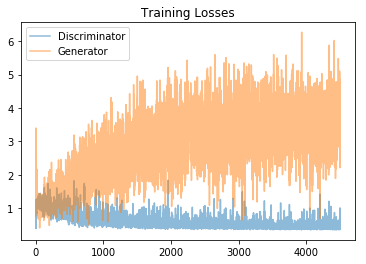

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

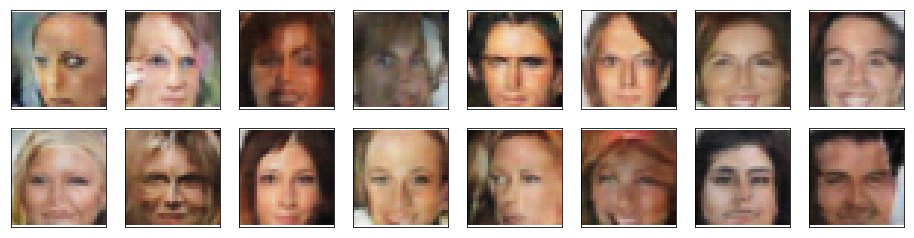

In [27]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

- Indeed the generated samples are 100% white and it could be helpful to enrich the dataset with less biased photos from other nationalities. 
- Both the generator and the discriminator had three convolutional layers and one linear layer so adding extra layers would improve the resolution of the pictures
- Also we could increase the size of the generated images (e.g. 64x64 or 128x128) 
- Finally we could further tweak hyperparameters or for example introduce a learning rate that evolves over time as it is recommended in the instructions

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.